# Bat Orientation Calls

The Bat Orientation Calls project focuses on classifying bat types using spectrograms in image format as input. Employing both a decision tree classifier and a convolutional neural network (CNN), our approach involves a systematic workflow detailed in this Jupyter notebook.

The initial stage involves loading and preprocessing the spectrogram images along with their corresponding labels. Spectrograms, visual representations of sound, exhibit the frequency content of an audio signal over time and serve as input data for classification. Ensuring the images are in a suitable format, we proceed to explore the data, gaining insights into its characteristics and distributions before venturing into modeling.

Setting up a decision tree classifier follows, utilizing a tree-like model to make decisions based on features extracted from the spectrogram images. The performance of the decision tree classifier is then scrutinized, analyzing metrics such as accuracy, precision, recall, and F1 score. Recognizing its limitations, we experiment with techniques like pruning, random forests, Bagging, AdaBoost, and Gradient Boosting to enhance generalization.

Transitioning to a CNN model, specifically designed for image classification, we train it on the spectrogram images to automatically learn and extract features, catering to the complexity of bat type classification. The CNN's outstanding performance is evaluated on the test data, surpassing the decision tree classifier. Visualizing learning curves aids in understanding the model's training process, while strategies like early stopping and dropout mitigate overfitting.

Subsequently, we compare the results of the decision tree classifier and the CNN model, providing insights into the effectiveness of traditional machine learning and deep learning in the context of bat orientation calls classification.

# 1. Loading, Preprocessing and Filtering the Images with their Labels

In [9]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from sklearn.preprocessing import LabelEncoder

The **load_images** function is designed to load and preprocess spectrogram images along with their corresponding labels. This function takes as input the paths to directories containing spectrogram images (`images_paths`), paths to CSV files containing image labels (`labels_paths`), and a list of valid labels (`valid_labels`). The function utilizes the Python Imaging Library (PIL) and pandas for efficient image handling and label extraction.

The loading process involves iterating through the provided image and label paths, reading the labels from CSV files, and matching them with the corresponding images. The images are then cropped to the size of the spectrogram and converted to numpy arrays, normalizing pixel values to the range [0, 1].

This code is crucial for preparing the input data for the machine learning models. By loading and preprocessing the images, it establishes the foundation for subsequent steps in the project. The use of PIL and pandas streamlines image handling and label extraction, contributing to the overall efficiency of the data preparation pipeline. The exclusion of images with missing or invalid labels ensures the dataset's integrity and quality, essential for reliable model training.

In [10]:
def load_images(images_paths, labels_paths, valid_labels):
    images = []
    labels = []

    no_label_counter = 0
    unidentified_counter = 0

    for images_path, labels_path in zip(images_paths, labels_paths):

        # Load labels from csv file
        labels_df = pd.read_csv(labels_path, sep=';')
        labels_df['Filename'] = [file[:-3] + 'png' for file in labels_df['Filename']]

        for filename in os.listdir(images_path):
            # Load the image using PIL
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path)

            # Crop the image to the size of the spectrogram
            left, upper, right, lower = 55, 36, 389, 252
            img = img.crop((left, upper, right, lower))

            # Convert image to numpy array and normalize
            img_array = np.array(img)[:, :, :3] / 255.0

            # Extract class label from the CSV file based on the image filename
            label_row = labels_df.loc[labels_df['Filename'] == filename]
            
            if label_row.empty:
                no_label_counter += 1
                continue

            label = label_row['Species'].values[0]

            if label not in valid_labels:
                unidentified_counter += 1
                continue
                
            labels.append(label)
            images.append(img_array)
                

    if no_label_counter:
        print(f'Label not found for {no_label_counter} images : Images will not be used.')
    if unidentified_counter:
        print(f'Bat unidentified for {unidentified_counter} images : Images will not be used.')

    return np.array(images), np.array(labels)

The `images_folders` and `labels_paths` variables store the paths to directories containing spectrogram images and corresponding CSV files with class labels, respectively.

By changing these paths, additional datasets can be added to the project, increasing the number of samples available but also the computational complexity of the project.

In [11]:
images_folders = ['./Data/dataset1'] #, './Data/dataset2', './Data/dataset3'
labels_paths = ['./Data/dataset1_classified.csv'] #, './Data/dataset2_classified.csv', './Data/dataset3_classified.csv'

Extracting valid labels is essential for establishing a comprehensive understanding of the dataset. By reading class labels from the specified CSV files, we utilize pandas to create a set of unique labels (`valid_labels`). The union of labels from multiple datasets ensures inclusivity.

In [12]:
# Extract the valid labels
valid_labels = set()
for labels_path in labels_paths:
    labels_df = pd.read_csv(labels_path, sep=';')
    valid_labels = valid_labels.union(set(labels_df['Species'].values))

print(f'Valid labels: {valid_labels}')

Valid labels: {'Langohrfledermaus', 'Bechsteinfledermaus', 'Fransenfledermaus', 'Mausohr', 'Wasserfledermaus', 'Bartfledermaus'}


Before model training, the label set is refined by excluding the specific invalid labels 'Fledermaus nicht bestimmbar' and 'Schwarzbild.' Additionally, non-alphabetical labels are filtered out, resulting in a cleaner and more focused list of valid labels.

In [13]:
# Remove invalid labels if they exist
invalid_labels = ['Fledermaus nicht bestimmbar', 'Schwarzbild']
valid_labels = [label for label in valid_labels if label not in invalid_labels]

# Remove non-alphabetical labels
valid_labels = [label for label in valid_labels if label.isalpha()]

print(f'Valid labels: {valid_labels}')
print(f'Number of valid labels: {len(valid_labels)}')

Valid labels: ['Langohrfledermaus', 'Bechsteinfledermaus', 'Fransenfledermaus', 'Mausohr', 'Wasserfledermaus', 'Bartfledermaus']
Number of valid labels: 6


To form the dataset for model training, spectrogram images and labels are loaded using the previously defined `load_images` function. The resulting dataset's shape is then printed, providing an overview of the number of images and labels loaded.

In [14]:
images, labels = load_images(images_folders, labels_paths, valid_labels)
print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

Images shape:  (582, 216, 334, 3)
Labels shape:  (582,)


Preparing for model training, we utilize scikit-learn's **LabelEncoder** to convert categorical class labels into numerical format. The fit_transform method is applied to the refined labels list, generating `encoded_labels`.

In [15]:
# Converting to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 2. Data Exploration

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

A visual representation of the spectrogram images is created for a subset of the dataset to aid in understanding the dataset's characteristics and provide insights into the variety of bat orientation calls.

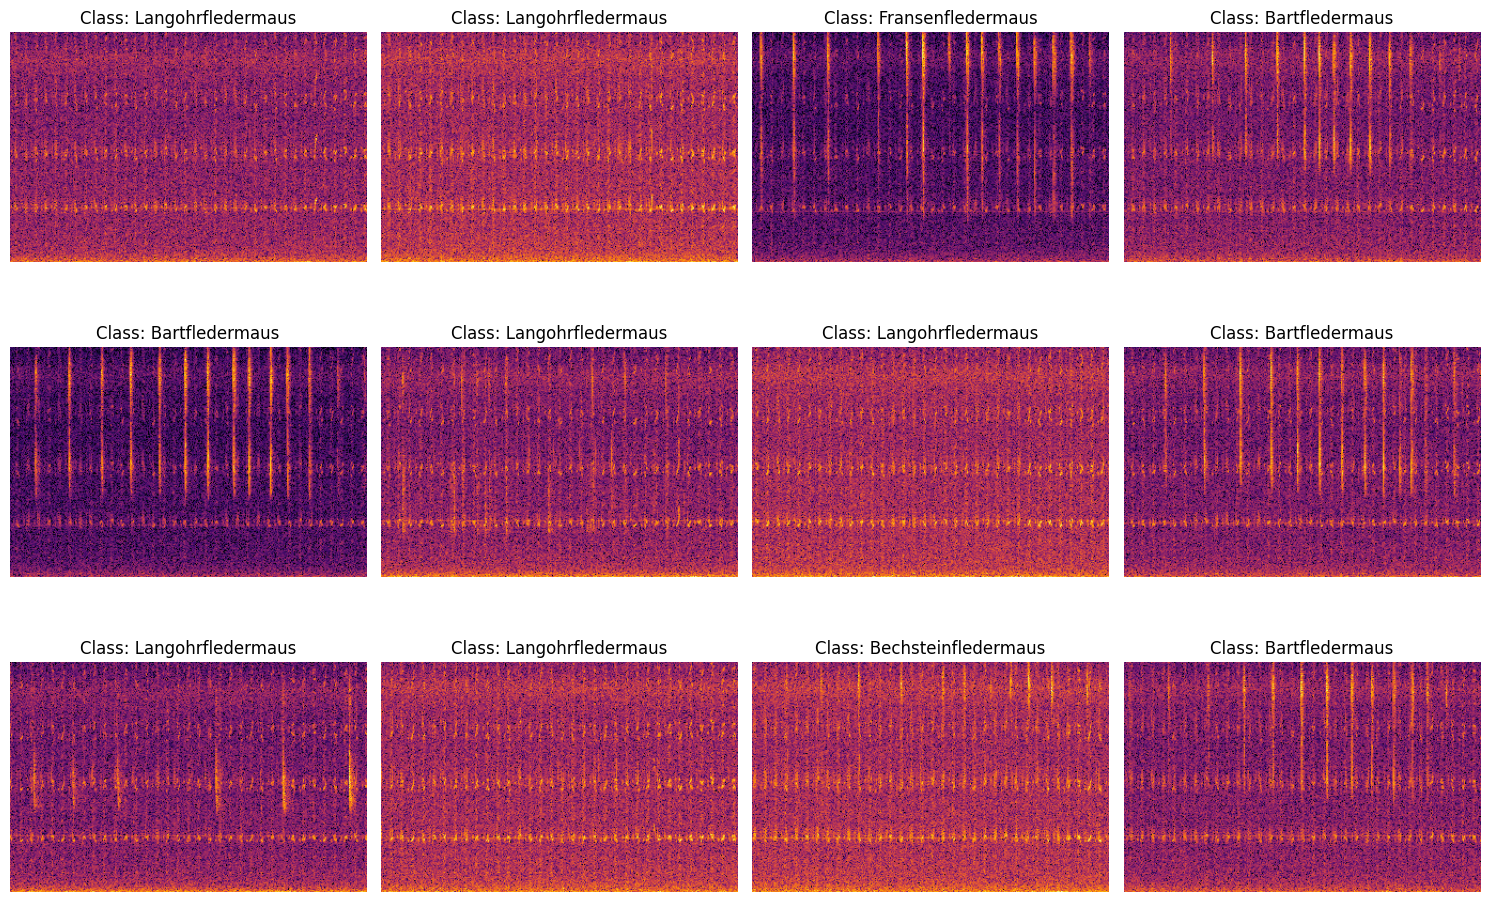

In [17]:
num_samples = 12
indices_to_visualize = random.sample(range(len(images)), num_samples)

num_cols = 4
num_rows = (num_samples + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, index in enumerate(indices_to_visualize):
    row = i // num_cols
    col = i % num_cols

    axes[row, col].imshow(images[index])
    axes[row, col].set_title(f'Class: {labels[index]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

We now use a bar chart to visualize the number of images we have for each bat type. By examining the distribution, we get a sense of the class distribution accross all bat types. With this, we  notice if we need to balance our data.

The exact counts showcase how underrepresented some of the bat types are.

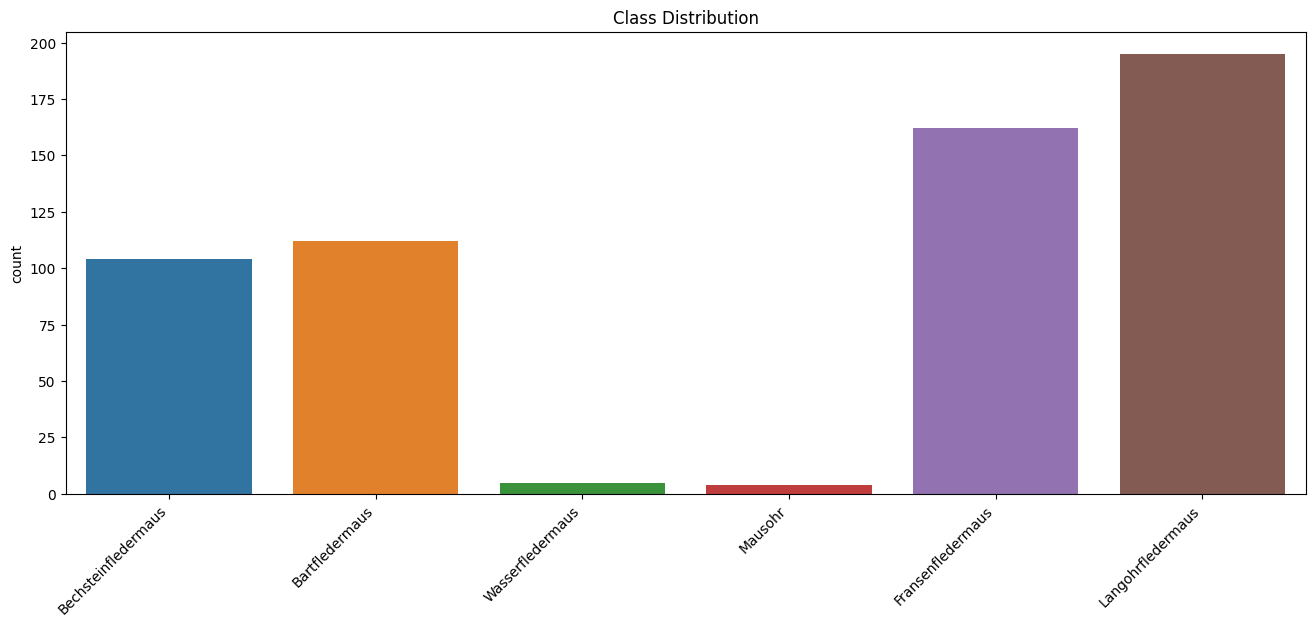

Langohrfledermaus      195
Fransenfledermaus      162
Bartfledermaus         112
Bechsteinfledermaus    104
Wasserfledermaus         5
Mausohr                  4
Name: count, dtype: int64


In [18]:
plt.figure(figsize=(16, 6))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

label_counts = pd.Series(labels).value_counts()
print(label_counts)

Performing some basic statistical analysis on our images and labels gives us an idea about the overall brightness and contrast of our images. We also check for missing values in our labels and images. Luckily, none need to be handled.

In [19]:
print('Mean of images: ', np.mean(images))
print('Std deviation of images: ', np.std(images))

empty_string_indices = labels == ''
print('Missing values in labels: ', np.sum(empty_string_indices))
print('Missing values in images: ', np.isnan(images).sum())

Mean of images:  0.3200254439126128
Std deviation of images:  0.22617266786506793
Missing values in labels:  0
Missing values in images:  0


# 3. Data Preparation

In [20]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator

### 3.1. Splitting the Dataset

In preparation for model training, the spectrogram images are flattened to create a one-dimensional representation (`images_flattened`). Subsequently, the dataset is split into training and testing sets for four different models: Decision Trees (DT), Feedforward Neural Network (FFNN), Convolutional Neural Network (CNN) and Pretrained Extractor + Decision Tree (PT). For the FFNN and CNN models a validation set is created additionally to facilitate model tuning and prevent overfitting.

In [21]:
# Flatten the images
images_flattened = images.reshape(images.shape[0], -1)

# Split the data for Decision Trees
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(images_flattened, encoded_labels, test_size=0.3, random_state=42)

# Split the data for FFNN
X_train_FFNN, X_test_FFNN, y_train_FFNN, y_test_FFNN = train_test_split(images_flattened, encoded_labels, test_size=0.3, random_state=42)
X_train_FFNN, X_val_FFNN, y_train_FFNN, y_val_FFNN = train_test_split(X_train_FFNN, y_train_FFNN, test_size=0.2, random_state=42)
# One-hot encode the labels
y_train_FFNN = to_categorical(y_train_FFNN)
y_val_FFNN = to_categorical(y_val_FFNN)
y_test_FFNN = to_categorical(y_test_FFNN)

# Split the data for CNN
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_CNN, y_train_CNN, test_size=0.2, random_state=42)

# Split the data for the pretrained Model
X_train_PT, X_test_PT, y_train_PT, y_test_PT = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)

### 3.2. Computing Class Weights

As we noticed huge class imbalances during data exploration we also calculate class weights to balance our data. We'll use these weights during training to ensure that our model doesn't become biased towards the majority classes.

In [22]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(encoded_labels),
                                                  y=encoded_labels)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

## 3. Decision Trees

## 3.1 Setting up a Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score

### 3.1.1 Basic Decision Tree

The Decision Tree model is initialized using the **DecisionTreeClassifier** from scikit-learn. The `class_weight` parameter is set to use our predefined weights (`class_weights_dict`). Subsequently, the model is trained using the `fit` method, establishing the decision tree's patterns and rules based on the flattened spectrogram images.

In [13]:
# Create the Decision Tree Classifier
DT_model = DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42)

# Train the model
DT_model.fit(X_train_DT, y_train_DT)

DecisionTreeClassifier(class_weight={0: 0.8660714285714286,
                                     1: 0.9326923076923077,
                                     2: 0.5987654320987654,
                                     3: 0.49743589743589745, 4: 24.25,
                                     5: 19.4},
                       random_state=42)

In [14]:
y_pred_DT = DT_model.predict(X_test_DT)

accuracy_DT = accuracy_score(y_test_DT, y_pred_DT)
print("Accuracy: ", accuracy_DT)

Accuracy:  0.37714285714285717


### 3.1.2 Pruned Decision Tree

In the process of optimizing the Decision Tree model, this code determines values for the **cost-complexity pruning** alpha (`ccp_alpha`). A subset of these alpha values is selected to train a Decision Tree model for each alpha value.

The code identifies the best alpha value by finding the one that maximizes the testing accuracy, providing a key parameter for refining the basic Decision Tree model.

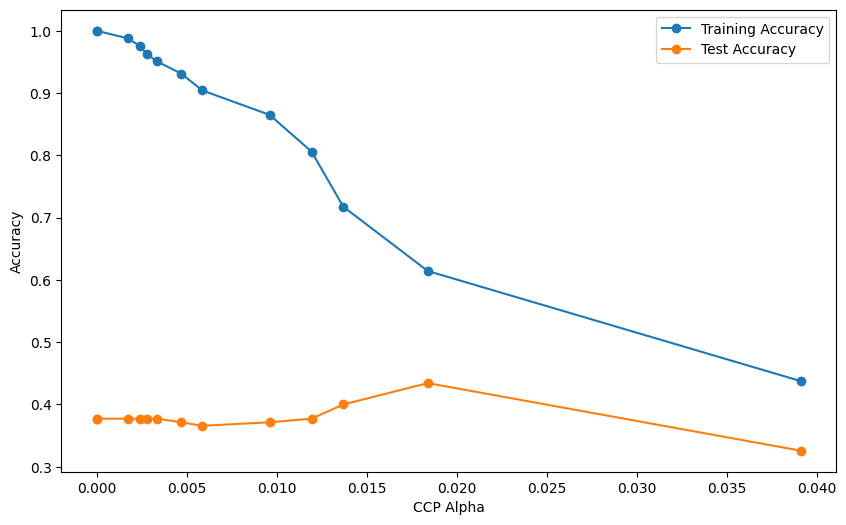

Best alpha value:  0.018391836179845633


In [19]:
# Determine values for alpha
path = DT_model.cost_complexity_pruning_path(X_train_DT, y_train_DT)
ccp_alphas = path.ccp_alphas

# Use a subset of ccp_alpha values
ccp_alphas_subset = ccp_alphas[::5]

# Create an array to store the accuracy of the models
train_acc = []
test_acc = []

# Iterate over the range of ccp_alpha values
for ccp_alpha in ccp_alphas_subset:
    # Create and train a decision tree with the current ccp_alpha
    clf = DecisionTreeClassifier(class_weight=class_weights_dict, ccp_alpha=ccp_alpha, random_state=42)
    clf.fit(X_train_DT, y_train_DT)

    # Calculate the training and validation accuracies
    y_train_pred = clf.predict(X_train_DT)
    y_test_pred = clf.predict(X_test_DT)

    train_acc.append(accuracy_score(y_train_DT, y_train_pred))
    test_acc.append(accuracy_score(y_test_DT, y_test_pred))

# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas_subset, train_acc, marker='o', label='Training Accuracy')
plt.plot(ccp_alphas_subset, test_acc, marker='o', label='Test Accuracy')
plt.xlabel('CCP Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the ccp_alpha with the highest accuracy
best_index = np.argmax(test_acc)
best_ccp_alpha = ccp_alphas_subset[best_index]
print("Best alpha value: ", best_ccp_alpha)

In [20]:
# Create a new Decision Tree Classifier with the best alpha value
DT_model_pruned = DecisionTreeClassifier(class_weight=class_weights_dict, ccp_alpha=best_ccp_alpha, random_state=42)

# Train the model
DT_model_pruned.fit(X_train_DT, y_train_DT)

DecisionTreeClassifier(ccp_alpha=0.018391836179845633,
                       class_weight={0: 0.8660714285714286,
                                     1: 0.9326923076923077,
                                     2: 0.5987654320987654,
                                     3: 0.49743589743589745, 4: 24.25,
                                     5: 19.4},
                       random_state=42)

In [21]:
y_pred_DT_pruned = DT_model_pruned.predict(X_test_DT)

accuracy_DT_pruned = accuracy_score(y_test_DT, y_pred_DT_pruned)
print("Accuracy (Pruning): ", accuracy_DT_pruned)

Accuracy (Pruning):  0.4342857142857143


### 3.1.3 Bagging Classifier

To enhance the robustness and generalization of the Decision Tree model, a Bagging Classifier is implemented. The pruned Decision Tree model (`DT_model_pruned`) serves as the base estimator for the ensemble. The **BaggingClassifier** is configured with 20 base estimators to try to mitigate overfitting and improve the overall performance of the Decision Tree model.

In [22]:
# Create a BaggingClassifier with the pruned Decision Tree as the base estimator
bag_DT_model = BaggingClassifier(estimator=DT_model_pruned, n_estimators=10, random_state=42)

# Train the model
bag_DT_model.fit(X_train_DT, y_train_DT)

In [ ]:
y_pred_bag_DT = bag_DT_model.predict(X_test_DT)

accuracy_bag_DT = accuracy_score(y_test_DT, y_pred_bag_DT)
print("Accuracy (Bagging): ", accuracy_bag_DT)

Accuracy (Bagging):  0.4857142857142857


### 3.1.4 Random Forest Classifier

To try to increase the overall robustness of the basic Decision Tree mode, the **RandomForestClassifier** is configured with 20 estimators. This ensemble tries to improve the model's predictive performance on unseen data.

In [24]:
# Create a RandomForestClassifier
RF_model = RandomForestClassifier(class_weight=class_weights_dict, n_estimators=10, random_state=42)

# Train the model
RF_model.fit(X_train_DT, y_train_DT)

RandomForestClassifier(class_weight={0: 0.8660714285714286,
                                     1: 0.9326923076923077,
                                     2: 0.5987654320987654,
                                     3: 0.49743589743589745, 4: 24.25,
                                     5: 19.4},
                       n_estimators=20, random_state=42)

In [25]:
y_pred_RF = RF_model.predict(X_test_DT)

accuracy_RF = accuracy_score(y_test_DT, y_pred_RF)
print("Accuracy (Random Forest): ", accuracy_RF)

Accuracy (Random Forest):  0.4514285714285714


### 3.1.5 AdaBoost Classifier

In the pursuit of optimizing model performance, an AdaBoost Classifier is explored with varying learning rates. A range of learning rates from 0.1 to 1.0 is considered. For each learning rate, an **AdaBoostClassifier** is instantiated with 10 base estimators (depth=1).
The code identifies the best learning rate by finding the one that maximizes testing accuracy, providing a key parameter for refining the AdaBoost model.

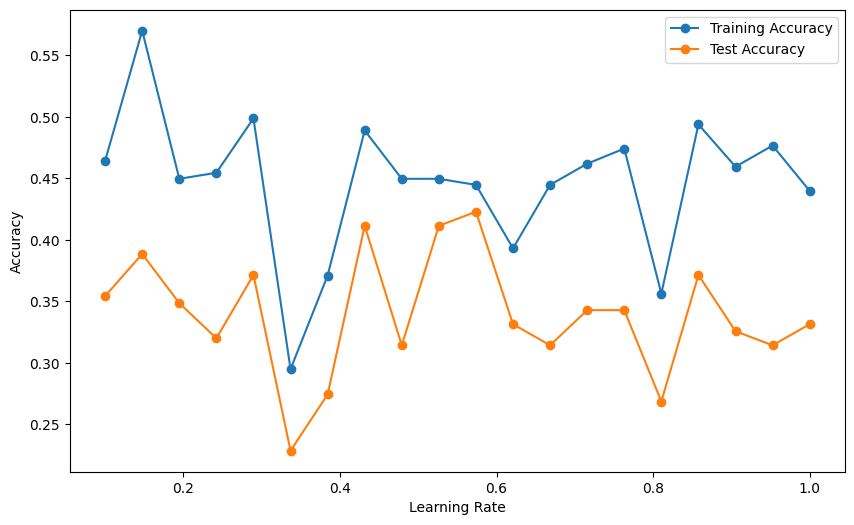

Best learning rate (ADA):  0.5736842105263158


In [26]:
learning_rates = np.linspace(0.1, 1.0, 20)

# Use a subset of the data
np.random.seed(42)
subset_indices = np.random.choice(np.arange(len(X_train_DT)), size=int(len(X_train_DT)*0.1), replace=False)
X_train_DT_subset = X_train_DT[subset_indices]
y_train_DT_subset = y_train_DT[subset_indices]

train_acc = []
test_acc = []

for learning_rate in learning_rates:
    # Create and train an AdaBoostClassifier with the current learning rate
    ADA_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, class_weight=class_weights_dict),
                                   n_estimators=10, learning_rate=learning_rate, random_state=42)
    ADA_model.fit(X_train_DT_subset, y_train_DT_subset)
    
    # Calculate the training and test accuracies
    y_train_pred = ADA_model.predict(X_train_DT_subset)
    y_test_pred = ADA_model.predict(X_test_DT)
    
    train_acc.append(accuracy_score(y_train_DT_subset, y_train_pred))
    test_acc.append(accuracy_score(y_test_DT, y_test_pred))

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_acc, marker='o', label='Training Accuracy')
plt.plot(learning_rates, test_acc, marker='o', label='Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the best learning rate
best_learning_rate = learning_rates[np.argmax(test_acc)]
print("Best learning rate (ADA): ", best_learning_rate)

In [27]:
# Train a new AdaBoostClassifier with the best learning rate
ADA_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, class_weight=class_weights_dict),
                               n_estimators=20, learning_rate=best_learning_rate, random_state=42)

# Train the model
ADA_model.fit(X_train_DT, y_train_DT)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.8660714285714286,
                                                                  1: 0.9326923076923077,
                                                                  2: 0.5987654320987654,
                                                                  3: 0.49743589743589745,
                                                                  4: 24.25,
                                                                  5: 19.4},
                                                    max_depth=1),
                   learning_rate=0.5736842105263158, n_estimators=20,
                   random_state=42)

In [30]:
y_pred_ADA = ADA_model.predict(X_test_DT)

accuracy_ADA = accuracy_score(y_test_DT, y_pred_ADA)
print("Accuracy (AdaBoost): ", accuracy_ADA)

Accuracy (AdaBoost):  0.4228571428571429


### 3.1.6 Gradient Boosting Classifier

In the pursuit of optimal model performance, a Gradient Boosting Classifier is examined with varying learning rates. A range of learning rates from 0.1 to 1.0 is considered. For each learning rate, a **GradientBoostingClassifier** is instantiated with 10 base estimators.

The code identifies the best learning rate by finding the one that maximizes testing accuracy, providing a key parameter for refining the Gradient Boosting model.

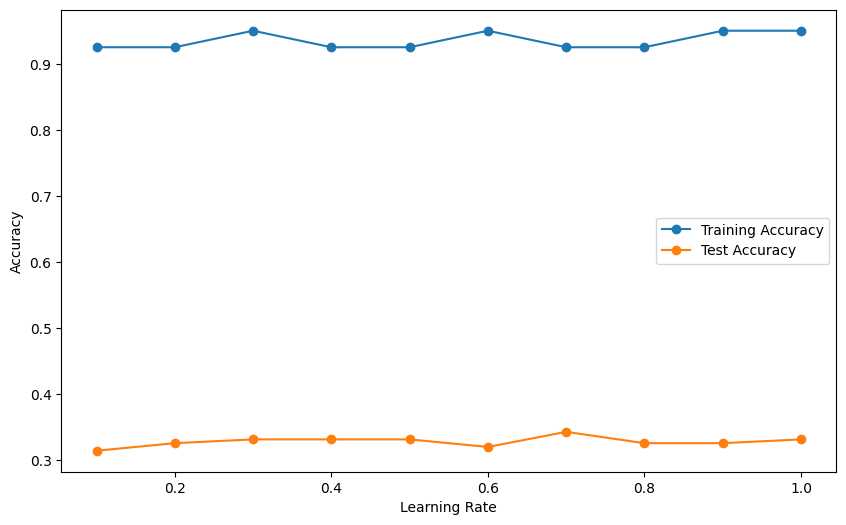

Best learning rate (GB):  0.7000000000000001


In [15]:
# Define the learning rates to try
learning_rates = np.linspace(0.1, 1.0, 10)

# Lists to store the training and test accuracies
train_acc = []
test_acc = []

# Try each learning rate
for learning_rate in learning_rates:
    # Create and train a GradientBoostingClassifier with the current learning rate
    GB_model = GradientBoostingClassifier(n_estimators=10, learning_rate=learning_rate,
                                          validation_fraction=0.1, n_iter_no_change=3,
                                          random_state=42)
    GB_model.fit(X_train_DT_subset, y_train_DT_subset)
    
    # Calculate the training and test accuracies
    y_train_pred = GB_model.predict(X_train_DT_subset)
    y_test_pred = GB_model.predict(X_test_DT)
    
    train_acc.append(accuracy_score(y_train_DT_subset, y_train_pred))
    test_acc.append(accuracy_score(y_test_DT, y_test_pred))

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_acc, marker='o', label='Training Accuracy')
plt.plot(learning_rates, test_acc, marker='o', label='Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the best learning rate
best_learning_rate = learning_rates[np.argmax(test_acc)]
print("Best learning rate (GB): ", best_learning_rate)

In [16]:
# Train a new GradientBoostingClassifier with the best learning rate
GB_model = GradientBoostingClassifier(n_estimators=10, learning_rate=best_learning_rate,
                                      validation_fraction=0.1, n_iter_no_change=3, tol=0.01, # Early stopping
                                      random_state=42)

# Train the model
GB_model.fit(X_train_DT, y_train_DT)

GradientBoostingClassifier(learning_rate=0.7000000000000001, n_estimators=10,
                           n_iter_no_change=3, random_state=42, tol=0.01)

In [17]:
y_pred_GB = GB_model.predict(X_test_DT)

accuracy_GB = accuracy_score(y_test_DT, y_pred_GB)
print("Accuracy (GradientBoost): ", accuracy_GB)

Accuracy (GradientBoost):  0.37142857142857144


## 3.2 Analyzing Decision Tree Results

In [74]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report

### 3.2.1 Comparing Accuracies

Comparing the accuracies of all created Decision Tree models, we notice that the Bagging Classifier achieved the highest accuracy. Therefore we use this model to further analyze the results.

In [1]:
accuracy_scores = [accuracy_DT, accuracy_DT_pruned, accuracy_bag_DT, accuracy_RF, accuracy_ADA, accuracy_GB]
models = ['DT', 'Pruned DT', 'Bagging DT', 'Random Forest', 'ADA-Boost', 'Gradient-Boost']

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color='blue', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across All DT Models')
plt.show()

### 3.2.2 Confusion Matrix

In the analysis of the best Decision Tree model, several key visualizations are generated. First, a confusion matrix is generated using the predicted labels (`y_pred_DT`) and the true labels (`y_test_DT`).

The confusion matrix is visualized using a heatmap with annotations, providing an insightful representation of the model's performance across different classes. The x-axis represents predicted classes, while the y-axis represents actual classes, and the color intensity indicates the number of instances. This visualization aids in assessing the model's accuracy and identifying any patterns of misclassification.

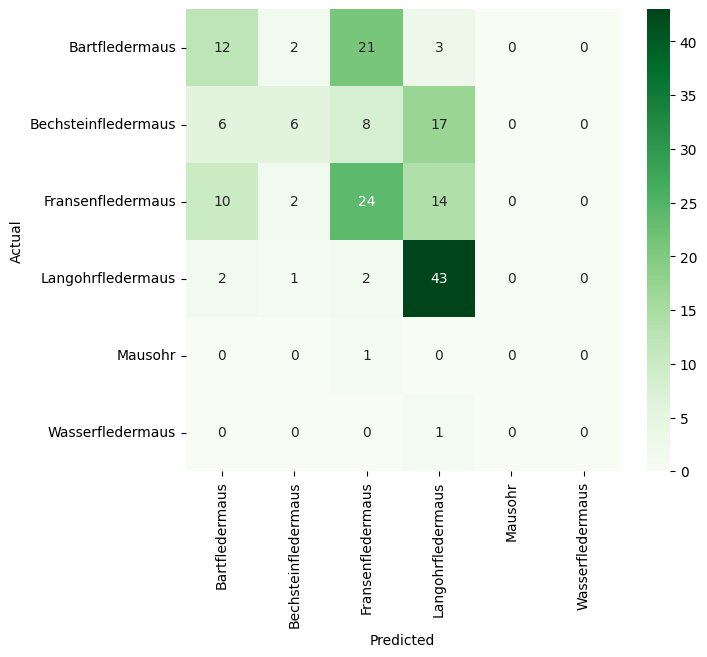

In [ ]:
# Extract unique classes present in the test dataset
unique_classes_test_DT = np.unique(y_test_DT)

# Convert encoded labels back to original classes
target_classes_DT = label_encoder.inverse_transform(unique_classes_test_DT)

# Generate confusion matrix
confusion_m_DT = confusion_matrix(y_test_DT, y_pred_bag_DT)

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_m_DT, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_DT, yticklabels=target_classes_DT)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 3.2.3 Classification Report

A classification report is generated to provide a detailed summary of the performance of the best Decision Tree model. The report includes key metrics such as precision, recall, and F1 score for each class.

In [ ]:
# Classification Report
report_DT = classification_report(y_test_DT, y_pred_bag_DT, target_names=target_classes_DT, zero_division=1, output_dict=True)
print(classification_report(y_test_DT, y_pred_bag_DT, target_names=target_classes_DT, zero_division=1)) # for formatting purposes

                     precision    recall  f1-score   support

     Bartfledermaus       0.40      0.32      0.35        38
Bechsteinfledermaus       0.55      0.16      0.25        37
  Fransenfledermaus       0.43      0.48      0.45        50
  Langohrfledermaus       0.55      0.90      0.68        48
            Mausohr       1.00      0.00      0.00         1
   Wasserfledermaus       1.00      0.00      0.00         1

           accuracy                           0.49       175
          macro avg       0.65      0.31      0.29       175
       weighted avg       0.49      0.49      0.45       175



### 3.2.4 Visualizing the best Decision Tree

The final analysis involves visualizing the structure of the basic Decision Tree model. Using the `plot_tree` function from the scikit-learn library, a tree diagram is generated to illustrate the decision-making process and the hierarchy of features within the model. Each node in the tree represents a decision based on a specific feature, with color intensity indicating the predominant class.

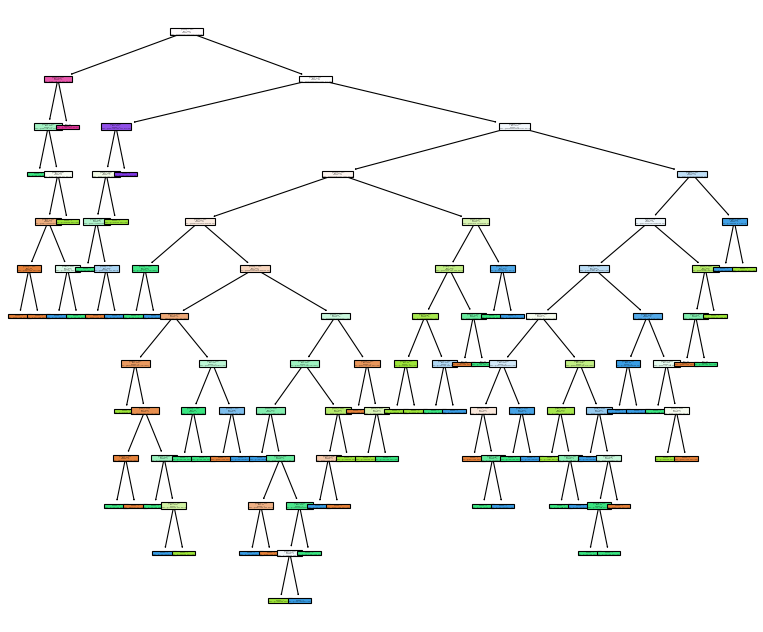

In [37]:
plt.figure(figsize=(12, 10), dpi=80)
tree.plot_tree(DT_model, filled=True)
plt.show()

# 4. Neural Networks

## 4.1 Setting up a FFNN Model

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from IPython.display import clear_output

### 4.1.1 Early Stopping and Custom Callback

Delving into the realm of neural networks, the focus shifts to creating a **Feedforward Neural Network (FFNN)** for the bat orientation calls classification task. To guide the training process and monitor the network's performance, we define an early stopping callback and a custom plot callback. These callbacks will be crucial in ensuring the network converges effectively as well as visualizing the training process.

1. **EarlyStopping:** This callback will stop training when a monitored quantity has stopped improving. We're monitoring the validation loss and will stop training if it doesn't improve for 10 epochs. This helps prevent overfitting and reduces computational waste.

2. **PlotInfo:** This is a custom callback we've defined. It plots the training and validation loss and accuracy after each epoch. This allows us to visually monitor our model's performance during training and can help us identify issues like overfitting or underfitting.

In [45]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define plot callback
class PlotInfo(keras.callbacks.Callback):
    def __init__(self):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.best_val_loss = float('inf')
        self.best_val_loss_epoch = 1
        self.best_val_accuracy = 0
        self.best_val_accuracy_epoch = 1

        self.epoch = 1
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(logs)
        self.x.append(self.epoch)

        self.losses.append(logs.get('loss', 0))
        self.val_losses.append(logs.get('val_loss', 0))
        self.accuracy.append(logs.get('accuracy', 0))
        self.val_accuracy.append(logs.get('val_accuracy', 0))

        # Check if current val_loss is the best so far
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            self.best_val_loss_epoch = self.epoch

        # Check if current val_accuracy is the best so far
        if logs.get('val_accuracy') > self.best_val_accuracy:
            self.best_val_accuracy = logs.get('val_accuracy')
            self.best_val_accuracy_epoch = self.epoch

        self.epoch += 1
        clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Subplot for loss
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.scatter(self.best_val_loss_epoch, self.best_val_loss, marker='o', color='red', label=f'best val_loss ({self.best_val_loss:.3f})')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.legend()

        # Subplot for accuracy
        ax2.plot(self.x, self.accuracy, label="accuracy")
        ax2.plot(self.x, self.val_accuracy, label="val_accuracy")
        ax2.scatter(self.best_val_accuracy_epoch, self.best_val_accuracy, marker='o', color='green', label=f'best val_accuracy ({self.best_val_accuracy:.3f})')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy')
        ax2.legend()

        fig.suptitle(f'Epoch {self.epoch - 1}', fontsize=16)
        plt.tight_layout()
        plt.show()

plot_info_FFNN = PlotInfo()

### 4.1.2 Creating the FFNN Model

In the creation of the Feedforward Neural Network (FFNN), we design a **Sequential** model using Keras. The architecture consists of several dense layers with varying numbers of neurons and activation functions. To enhance the network's robustness and prevent overfitting, batch normalization and dropout layers are strategically incorporated.

The model is compiled using categorical crossentropy as the loss function and the Adam optimizer. Training is executed over 50 epochs with a batch size of 32, incorporating early stopping and a custom plot callback for real-time visualization of training progress.

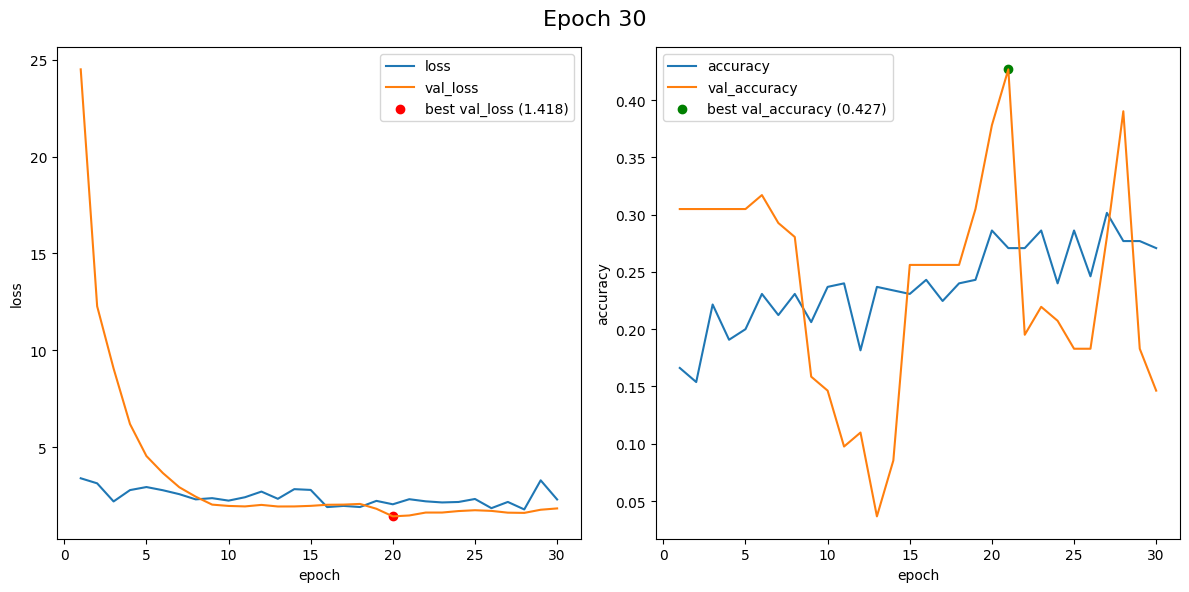

11/11 [==============================] - 1s 131ms/step - loss: 2.2916 - accuracy: 0.2708 - val_loss: 1.8284 - val_accuracy: 0.1463


In [47]:
FFNN_model = Sequential()

FFNN_model.add(Dense(128, input_dim=X_train_FFNN.shape[1], activation='relu')) #, kernel_regularizer=l2(0.01)
FFNN_model.add(BatchNormalization())
FFNN_model.add(Dropout(0.5))

FFNN_model.add(Dense(64, activation='relu'))
FFNN_model.add(BatchNormalization())
FFNN_model.add(Dropout(0.5))

FFNN_model.add(Dense(32, activation='relu'))
FFNN_model.add(BatchNormalization())
FFNN_model.add(Dropout(0.5))

FFNN_model.add(Dense(y_train_FFNN.shape[1], activation='softmax'))

FFNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_FFNN = FFNN_model.fit(X_train_FFNN, y_train_FFNN,
                              epochs=50, batch_size=32,
                              validation_data=(X_val_FFNN, y_val_FFNN),
                              class_weight=class_weights_dict,
                              callbacks=[early_stopping, plot_info_FFNN])

In [48]:
FFNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               27703424  
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

## 4.2. Analyzing FFNN Results

### 4.2.1 Loss and Accuracy

To evaluate the Feedforward Neural Network (FFNN), we analyze the model's performance on the test set using the metrics **loss** and **accuracy**.

In [49]:
# Evaluate the model on the test set
y_pred_FFNN = FFNN_model.predict(X_test_FFNN)
loss, accuracy = FFNN_model.evaluate(X_test_FFNN, y_test_FFNN)

6/6 [==============================] - 0s 13ms/step - loss: 1.3985 - accuracy: 0.4457


### 4.2.2 Confusion Matrix

Additionally, a confusion matrix as well as a classification report is created to visualize the distribution of predicted and actual labels across different classes.

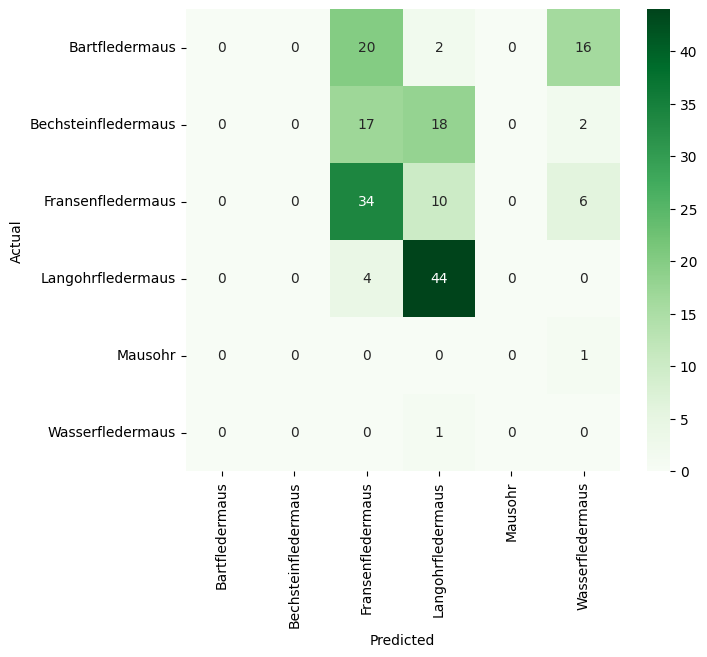

In [52]:
# Convert one-hot encoded y_test_FFNN and y_pred_FFNN back to label encoded form
y_test_FFNN_label_encoded = np.argmax(y_test_FFNN, axis=1)
y_pred_FFNN_label_encoded = np.argmax(y_pred_FFNN, axis=1)

# Extract unique classes present in the test dataset
unique_classes_test_FFNN = np.unique(y_test_FFNN_label_encoded)

# Convert encoded labels back to original classes
target_classes_FFNN = label_encoder.inverse_transform(unique_classes_test_FFNN)

# Generate confusion matrix
confusion_m_FFNN = confusion_matrix(y_test_FFNN_label_encoded, y_pred_FFNN_label_encoded)

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_m_FFNN, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_FFNN, yticklabels=target_classes_FFNN)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 4.2.3 Confusion Matrix

In [55]:
# Classification Report
report_FFNN = classification_report(y_test_FFNN_label_encoded, y_pred_FFNN_label_encoded, target_names=target_classes_FFNN, zero_division=1, output_dict=True)
print(classification_report(y_test_FFNN_label_encoded, y_pred_FFNN_label_encoded, target_names=target_classes_FFNN, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       1.00      0.00      0.00        38
Bechsteinfledermaus       1.00      0.00      0.00        37
  Fransenfledermaus       0.45      0.68      0.54        50
  Langohrfledermaus       0.59      0.92      0.72        48
            Mausohr       1.00      0.00      0.00         1
   Wasserfledermaus       0.00      0.00      1.00         1

           accuracy                           0.45       175
          macro avg       0.67      0.27      0.38       175
       weighted avg       0.72      0.45      0.36       175



## 4.3 Setting up a CNN Model

In [56]:
from keras import layers, models

from keras_tuner.tuners import RandomSearch
from keras.callbacks import ModelCheckpoint

We're now transitioning from models that use flat input to models with actual feature recognition in images. We've chosen to use a **Convolutional Neural Network (CNN)** for our task. CNNs are particularly effective for image classification tasks because they can automatically learn and extract features from images, which can be more effective than manually engineered features.

We'll be using the Keras library to build our CNN.

### 4.3.1 Data Augmentation

We decided to aditionally combat class inbalance using data augmentation. Using Keras's **ImageDataGenerator** enables us to significantly increase the diversity of data available for training models, without actually collecting new data. 

Our augmentation techniques include slight shifts in width and height, and channel shifts.
We decided against horizontal and vertical flips as well as rotation as this would totally change the information inside the spectrogram.

This technique can help the model generalize better to new data, as it provides a way of artificially introducing sample variability by applying random image changes. 

In [57]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range = 0.025,
    height_shift_range = 0.015,
    channel_shift_range= 0.2
)

To see the types of transformations our data augmentation is applying, we generate a few augmented images from our training set and plot them next to the original images. This allows us to ensure they're sensible for our task.

Using this we can tune the parameters of our data augmentation to ensure that our augmentation techniques are providing a good variety of images for our model to learn from, without distorting the images.

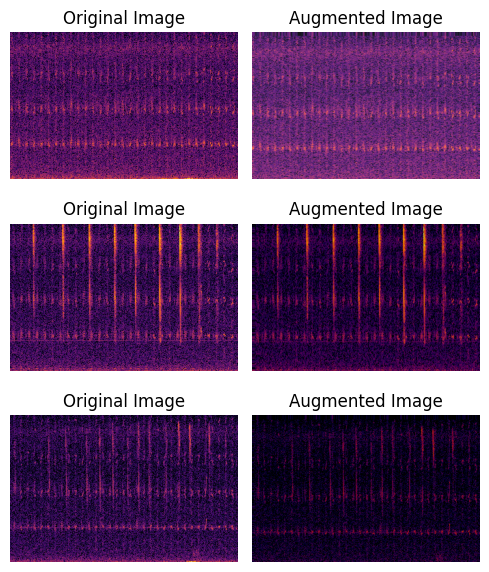

In [58]:
# Generate augmented images
augmented_images = datagen.flow(X_train_CNN, batch_size=1, shuffle=False)

# Plot original and augmented images
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(5, 6))

for i in range(num_samples):
    # Original Image
    original_image = X_train_CNN[i]
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Augmented Image
    augmented_image = augmented_images.next()[0]
    axes[i, 1].imshow(augmented_image)
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### 4.3.2 Creating the CNN Model

Now we have to define our Convolutional Neural Network (CNN) model. We're again using Keras's **Sequential** model, which allows us to stack layers on top of each other. Here's why we chose these specific layers:

1. **Conv2D layers:** These are the convolutional layers that will learn the features in our images. We're using 3x3 filters, which is a common choice. We're also using the ReLU activation function, which helps the model learn complex patterns. The number of filters in each Conv2D layer is a hyperparameter that we'll tune.

2. **MaxPooling2D layers:** These layers reduce the spatial dimensions of our data, which makes the model more computationally efficient and helps it detect features regardless of their position in the image. We're using 2x2 pooling windows.

3. **Flatten layer:** This layer reshapes our 3D data into 1D data so it can be fed into the dense layer.

4. **Dense layers:** These are fully connected layers that will learn patterns in the features extracted by the Conv2D layers.

5. **Dropout layers:** These layers randomly set a fraction of the input units to 0 during training, which helps prevent overfitting.

6. **Output layer:** This layer outputs the probabilities of each class. We're using the softmax activation function, which ensures that the output probabilities sum to 1.

Finally, we compile our model with the Adam optimizer and the sparse categorical crossentropy loss function.

We're using the **RandomSearch** class from Keras Tuner to tune our hyperparameters. This class will randomly select combinations of hyperparameters for the number of filters in each Conv2D layer, the size of the dense layer, the amount of dropout for each Dropout layer as well as the general learning rate. Afterwards, it will train the model on random combinations.

We're aiming to maximize validation accuracy. The results will be saved in the specified directory.

In [59]:
# Define a function to build the model with hyperparameters
def build_model(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(216, 334, 3)))
    model.add(layers.Dropout(hp.Float('dropout_conv1', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_conv2', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_conv3', min_value=0.05, max_value=0.2, step=0.05)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, directory='./cnn-model/tuner_results', project_name='cnn_tuner',
                     overwrite=True)

### 4.3.3 Custom Callbacks

To make our tuner work more effectively, we're defining two new callbacks to use during model training.

1. **LowAccuracy:** This is a custom callback we've defined. It stops training if the validation accuracy is below a certain threshold for a certain number of epochs. This can save time if the chosen parameters are not effective for training the model.

2. **ModelCheckpoint:** This callback saves the model after every epoch. We're saving only the model that has the best validation accuracy. This allows us to use the best model even if training is stopped early or if the model's performance decreases in later epochs.

By using these callbacks as well as the previous ones, we can have more control over the training process, making it more efficient and effective.

In [62]:
# Define low accuracy callback
class LowAccuracy(keras.callbacks.Callback):
    def __init__(self, threshold, patience):
        super(LowAccuracy, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)
        if val_accuracy < self.threshold:
            self.counter += 1
        if self.counter >= self.patience:
            self.counter = 0
            self.model.stop_training = True

low_accuracy = LowAccuracy(threshold=0.02, patience=5)


# Define model checkpoint callback
checkpoint_path = './cnn-model/model_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Define a new plot callback
plot_info_CNN = PlotInfo()

### 4.3.4 Training and Tuning the CNN Model

Now, let's start the hyperparameter search process. We're using the `search` method of our tuner object, which will train our model with different combinations of hyperparameters and find the best ones.

We're passing our augmented training and validation data to the method. We're also specifying the number of epochs to train for, the class weights to use, and the callbacks we defined earlier.

This process can take a long time (around 16 hours when including all datasets), depending on the number of hyperparameters we're tuning and the number of trials we're trying out. But at the end, we'll have a model that's mostly optimized for our specific task.

In [63]:
# Search for the best hyperparameters
tuner.search(datagen.flow(X_train_CNN, y_train_CNN, batch_size=32),
             epochs=50,
             validation_data=datagen.flow(X_val_CNN, y_val_CNN, batch_size=32),
             class_weight=class_weights_dict,
             callbacks=[early_stopping, low_accuracy, plot_info_CNN, model_checkpoint])

Trial 10 Complete [00h 17m 56s]
val_accuracy: 0.792682945728302

Best val_accuracy So Far: 0.8414633870124817
Total elapsed time: 02h 29m 51s


Of all the trained models from our hyperparameter search, we obviously want to retrieve the best model. The `get_best_models` method of our tuner object returns the top models, ranked by their performance on the validation data. We're only interested in the top model, so we specify `num_models=1`.

In [64]:
# Get the best model
best_CNN_model = tuner.get_best_models(num_models=1)[0]

To get a sense of how large the model is, we use the `summary` method of our model object. This shows us the layers in our model and the number of parameters in each layer.

In [65]:
best_CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 332, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 214, 332, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 107, 166, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 164, 64)      36928     
                                                                 
 dropout_1 (Dropout)         (None, 105, 164, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 82, 64)        0         
 g2D)                                                   

After extracting the best found model, we train it again to give it a chance to further learn from our data and improve its performance.

The `fit` method returns a history object, which contains information about the training process, such as the loss and accuracy values at each epoch. We could use this object later to plot our training and validation loss and accuracy, but our plot callback takes care of that. 

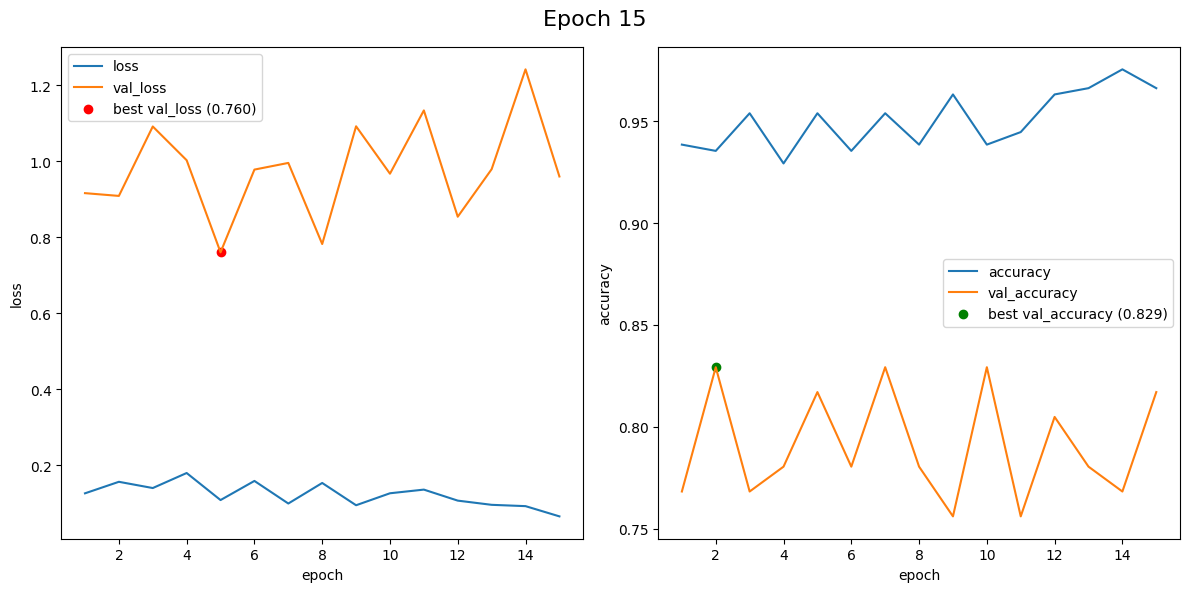

11/11 [==============================] - 30s 3s/step - loss: 0.0650 - accuracy: 0.9662 - val_loss: 0.9598 - val_accuracy: 0.8171


In [66]:
# Train the best model again
history_CNN = best_CNN_model.fit(datagen.flow(X_train_CNN, y_train_CNN, batch_size=32),
                                 epochs=50,
                                 class_weight=class_weights_dict,
                                 validation_data=datagen.flow(X_val_CNN, y_val_CNN, batch_size=32),
                                 callbacks=[early_stopping, model_checkpoint, plot_info_CNN])

After the best model finished training again, we save it to a file. This allows us to load the model later without having to retrain it. This saves huge amounts of time, as we skip the hyperparameter search process and go straight to model evaluation.

In [67]:
# Save the trained model
best_CNN_model.save('./cnn-model/best_model.keras')

In [68]:
# Load the trained model
CNN_model = keras.models.load_model('./cnn-model/best_model.keras')

## 4.4 Analyzing CNN Results

### 4.4.1 Loss and Accuracy

To evaluate the performance of our trained model on the test set, we use the `evaluate` method of our model object. This method returns the loss and accuracy values for the model in test mode.

In [69]:
# Evaluate the best model on the test set
y_pred_CNN = CNN_model.predict(X_test_CNN)
test_loss, test_acc = CNN_model.evaluate(X_test_CNN, y_test_CNN)

6/6 [==============================] - 2s 245ms/step - loss: 0.6943 - accuracy: 0.8629


### 4.4.2 Confusion Matrix

To better visualize the performance of our model on the test set for each class individually, we generate a confusion matrix. This allows us to see which classes our model is good at predicting and which ones it struggles with, helping us identify areas where our model could be improved.

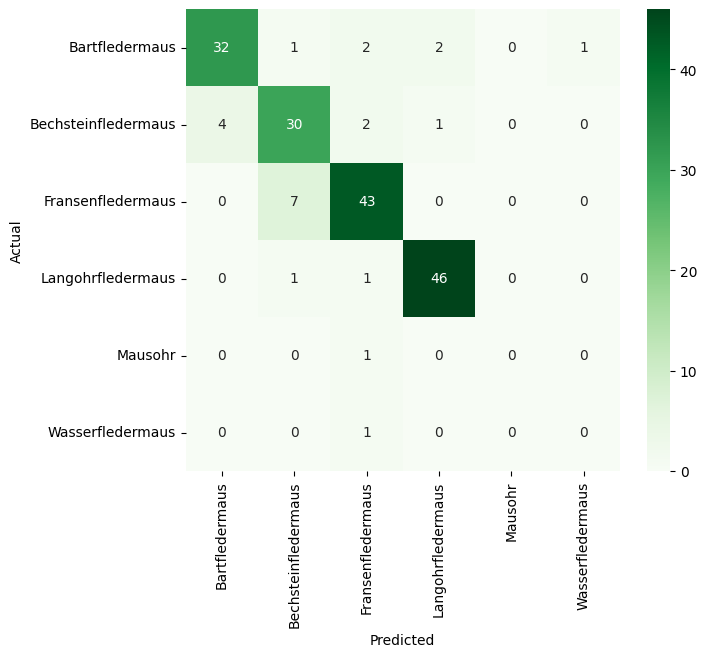

In [72]:
# Convert one-hot encoded y_pred_CNN back to label encoded form
y_pred_CNN_label_encoded = np.argmax(y_pred_CNN, axis=1)

# Extract unique classes present in the test dataset
unique_classes_test_CNN = np.unique(y_test_CNN)

# Convert encoded labels back to original classes
target_classes_CNN = label_encoder.inverse_transform(unique_classes_test_CNN)

# Generate confusion matrix
confusion_m_CNN = confusion_matrix(y_test_CNN, y_pred_CNN_label_encoded)

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_m_CNN, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_CNN, yticklabels=target_classes_CNN)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 4.4.3 Classification Report

To get a more detailed view of our model's performance, we generate a classification report. This presents us the precision, recall, f1-score, and support for each class.

In [74]:
# Classification Report
report_CNN = classification_report(y_test_CNN, y_pred_CNN_label_encoded, target_names=target_classes_CNN, zero_division=1, output_dict=True)
print(classification_report(y_test_CNN, y_pred_CNN_label_encoded, target_names=target_classes_CNN, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       0.89      0.84      0.86        38
Bechsteinfledermaus       0.77      0.81      0.79        37
  Fransenfledermaus       0.86      0.86      0.86        50
  Langohrfledermaus       0.94      0.96      0.95        48
            Mausohr       1.00      0.00      0.00         1
   Wasserfledermaus       0.00      0.00      1.00         1

           accuracy                           0.86       175
          macro avg       0.74      0.58      0.74       175
       weighted avg       0.86      0.86      0.87       175



# 5. Using a Pretrained Feature Extractor

## 5.1 Setting up a Pretrained Model and a Decision Tree

While training models from scratch can be very effective, it can also be very time-consuming and computationally expensive. Luckily, there are other options. One of these is using a **pretrained model** to extract features from the images. 

These features can then be used as input for a simpler model, such as a **DecisionTreeClassifier**.

Therefore you can achieve very good performance in a fraction of the time it would take to set up and train a model from scratch.

### 5.1.1 Model Setup and Feature Extraction

In [5]:
import keras.utils as image
from keras.applications.vgg16 import VGG16, preprocess_input

In [26]:
# Create the VGG16 model to use for feature extraction
PT_model = VGG16(weights='imagenet', include_top=False)

In [4]:
# Extract image features using a pretrained model
def extract_features(img, model):
    # Turn the image into a numpy array
    x = image.img_to_array(img)

    # prepare the image for the VGG model
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract the features from the image
    features = model.predict(x)
    return features.flatten()

In [32]:
# Extract features from the training set using the pretrained model
X_train_PT_features = np.array([extract_features(img, PT_model) for img in X_train_PT])
X_test_PT_features = np.array([extract_features(img, PT_model) for img in X_test_PT])

1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 124ms/step


### 5.1.2 Classification

Just like with the flattened images before, the Decision Tree is used to classify the images, only this time using the features extracted by the pretrained model.

In [69]:
# Create the Decision Tree for classifying the extracted features
DT_model_PT = DecisionTreeClassifier(max_depth=4, random_state=42)

# Train the model
DT_model_PT.fit(X_train_PT_features, y_train_PT)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [75]:
# predict the labels for the test set
y_pred_DT_PT = DT_model_PT.predict(X_test_PT_features)

accuracy_DT_PT = accuracy_score(y_test_PT, y_pred_DT_PT)

## 5.2 Analyzing Pretrained Feature Extractor Results

### 5.2.1 Confusion Matrix

To better visualize the performance of this solution as well as compare it to the previous models, we once again generate a confusion matrix and a classification report.

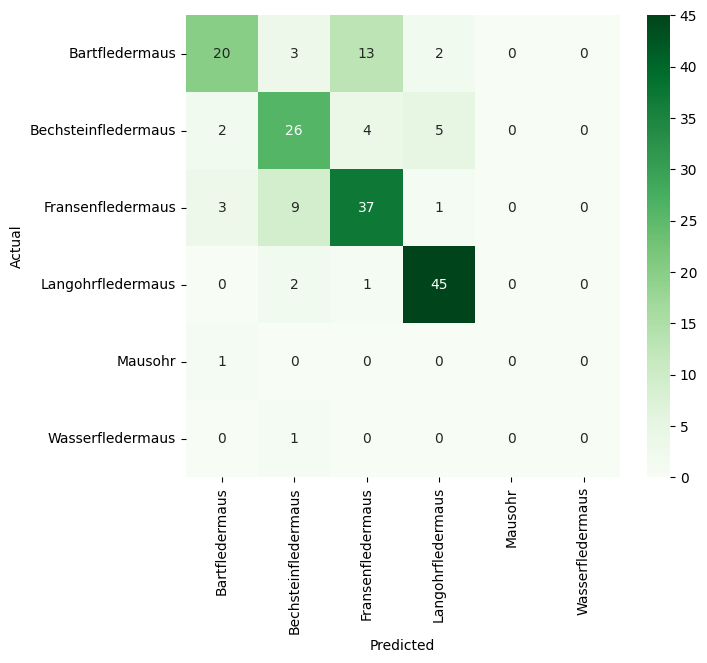

In [76]:
# Extract unique classes present in the test dataset
unique_classes_test_PT = np.unique(y_test_PT)

# Convert encoded labels back to original classes
target_classes_PT = label_encoder.inverse_transform(unique_classes_test_PT)

# Generate confusion matrix
confusion_m_PT = confusion_matrix(y_test_PT, y_pred_DT_PT)

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_m_PT, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_PT, yticklabels=target_classes_PT)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 5.2.2 Classification Report

In [77]:
# Classification Report
report_PT = classification_report(y_test_PT, y_pred_DT_PT, target_names=target_classes_PT, zero_division=1, output_dict=True)
print(classification_report(y_test_PT, y_pred_DT_PT, target_names=target_classes_PT, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       0.77      0.53      0.62        38
Bechsteinfledermaus       0.63      0.70      0.67        37
  Fransenfledermaus       0.67      0.74      0.70        50
  Langohrfledermaus       0.85      0.94      0.89        48
            Mausohr       1.00      0.00      0.00         1
   Wasserfledermaus       1.00      0.00      0.00         1

           accuracy                           0.73       175
          macro avg       0.82      0.48      0.48       175
       weighted avg       0.74      0.73      0.72       175



# 6. Comparing Results

To compare the evaluation results of the best Decision Tree model, the FFNN model and the CNN model, we generate a radar chart. This chart provides a visual representation of the performance of each model across the metrics precision, recall and F1 score.

Beside it, the training histories of the FFNN and CNN models are visualized, displaying how different the models learn over time.

### 6.1 Preparing results

In [28]:
# Define function to retreive data from classification report
def extract_classification_report(report):
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    return list((precision, recall, f1_score))

In [29]:
report_data_DT = extract_classification_report(report_DT)
report_data_FFNN = extract_classification_report(report_FFNN)
report_data_CNN = extract_classification_report(report_CNN)
report_data_PT = extract_classification_report(report_PT)

report_data_DT.append(report_data_DT[0])
report_data_FFNN.append(report_data_FFNN[0])
report_data_CNN.append(report_data_CNN[0])
report_data_PT.append(report_data_PT[0])

[0.3660122528543582, 0.37714285714285717, 0.3797874229068608, 0.3660122528543582]


### 6.2 Radar Charts (Precision, Recall, F1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))

# Radar chart
labels = np.array(["Precision", "Recall", "F1-score"])
angles = np.linspace(0, 2 * np.pi, 3, endpoint=False).tolist()
angles.append(angles[0])

ax1.fill(angles, report_data_DT, color='red', alpha=0.25)
ax1.plot(angles, report_data_DT, color='red', label='Decision Tree')

ax1.fill(angles, report_data_FFNN, color='blue', alpha=0.25)
ax1.plot(angles, report_data_FFNN, color='blue', label='FFNN')

ax1.fill(angles, report_data_CNN, color='green', alpha=0.25)
ax1.plot(angles, report_data_CNN, color='green', label='CNN')

ax1.fill(angles, report_data_PT, color='orange', alpha=0.25)
ax1.plot(angles, report_data_PT, color='orange', label='Pretrained Model')

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(labels)

ax1.yaxis.grid(True)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_rlabel_position(30)

ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax1.set_title('Precision, Recall and F1-score accross the models')

# Training history
ax2 = plt.subplot(1, 2, 2)

ax2.plot(history_FFNN.history['accuracy'], label='FFNN accuracy')
ax2.plot(history_FFNN.history['val_accuracy'], label='FFNN val_accuracy')
ax2.plot(history_CNN.history['accuracy'], label='CNN accuracy')
ax2.plot(history_CNN.history['val_accuracy'], label='CNN val_accuracy')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training history of both FFNN and CNN')

plt.show()

### 6.3 Confusion Matrices

Last but not least, we visualize the confusion matrices of the best Decision Tree model, the FFNN model and the CNN model side by side to provide a comprehensive overview of the models' performance across different classes.

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(2, 2, figsize=(18, 6))

# Decision Tree
sns.heatmap(confusion_m_DT, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_DT, yticklabels=target_classes_DT, ax=ax1)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
ax1.set_title('Decision Tree')

# FFNN
sns.heatmap(confusion_m_FFNN, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_FFNN, yticklabels=target_classes_FFNN, ax=ax2)
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")
ax2.set_title('FFNN')

# CNN
sns.heatmap(confusion_m_CNN, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_CNN, yticklabels=target_classes_CNN, ax=ax3)
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Actual")
ax3.set_title('CNN')

# Pretrained Model
sns.heatmap(confusion_m_PT, annot=True, fmt='d', cmap='Greens', xticklabels=target_classes_PT, yticklabels=target_classes_PT, ax=ax4)
ax4.set_xlabel("Predicted")
ax4.set_ylabel("Actual")
ax4.set_title('Pretrained Model')

plt.show()